# Trentino Data Workbook

## Ideas brainstorming

1. Ideas for internet traffic data
   1. Explore internet traffic activity across the region
   2. Predict temporal internet traffic
   3. Predict spatiotemporal internet traffic
   4. Depending on the internet traffic demand, propose new Cell Towers or 
Virtual Base Stations to relief the network from hot spot areas.

In this workbook, data from various sources are brought together to enable informed decisions such as possible investment opporunities, new product launches etc. The dataset used, are Trento grid files, Internet usage and cell towers (LTE, 4G).

## UE-VBS concept

UE-based Virtual Base Station (UE-VBS) enables the Smartphones (i.e., User Equipment) of the general population to be enhanced with Base Station and Relay Node functionalities and be embedded as an integral part of the Mobile Network Infrastructure, offering relief in stressful or overloaded situations. 

The aforementioned approach is extensively discussed in [this paper](https://doi.org/10.1016/j.comnet.2021.107926).



## Aims and objectives

We would like to explore the network coverage with respect to internet traffic demand. Questions like, do we need more base stations (cell towers) to accomodate the demand? Will we need in the future if the demand continues to grow? Do we need increased coverage for certain hours in certain areas?

Insight driven decisions can be made from the telecommunication companies. These can be:
 - Enhance network
 - Relief hot spot areas using the concept of UE-VBS
 - Develop specialised products for rural areas
 - Land new products (WIFI) for areas with high demand but not sufficient coverage
 - Might want to explore the purchase power of people living in those areas and propose the appropirate product.

The concept behind the need for prediction of internet usage in particular areas at particular times occurs by the nature of the contracts which the telecommunication companies will sign with individuals from the general populations to act as Virtual Small Cells or Relay Stations. The contracts can be in the form of pay as go which and thus, there is a need to predict when the demand will be higher and sign contract with the appropriate number of people to relief the network. This will enable a cost effective approach in realising this approach.

Questions we would like to answer:
 - Does internet usage vary with respect to the time in a day?
 - Does internet usage vary with respect to weekday?
 - If possible identify if same internet usage is needed throughout the month. 

 Assumptions:
 - All the data refer to the same period



In [121]:
import json
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from matplotlib.colors import to_rgba
from shapely.geometry import Point, Polygon
from sklearn import preprocessing
from sklearn.cluster import KMeans,DBSCAN
from pylab import *
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import griddata
from scipy import interpolate
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from sklearn import metrics
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Activation
from keras import optimizers
from keras.layers import Dropout
import tsfresh
from tsfresh.utilities.dataframe_functions import roll_time_series

In [122]:
# declare minmax latitude and longitude as constants
MIN_LON = 10.447119177280248
MAX_LON = 11.969941745503913
MIN_LAT = 45.67235949990072
MAX_LAT = 46.53697620716745

In [123]:
# import telecommunication data for trentino area
df_telcom_raw = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/KPMG_Assignment/data/Internet_traffic_activity.csv',header=None)  
# change column names to meaningful values
df_telcom_raw.columns =['Square_id','Timestamp','Internet_traffic_activity']
# copy raw data to processed (copies only the reference to the object) 
df_telcom_processed = df_telcom_raw.copy()
# drop duplicates found in the dataset
df_telcom_processed.drop_duplicates(inplace=True)
# convert timestamp column to datetime type
df_telcom_processed.Timestamp = pd.to_datetime(df_telcom_processed.Timestamp, format='%Y-%m-%d %H:%M')
print(df_telcom_processed.dtypes)
df_telcom_processed

Square_id                             int64
Timestamp                    datetime64[ns]
Internet_traffic_activity           float64
dtype: object


,Square_id,Timestamp,Internet_traffic_activity
0,10000,2013-12-01 00:00:00,9.381368
1,10000,2013-12-01 01:00:00,11.966050
2,10000,2013-12-01 02:00:00,10.588980
3,10000,2013-12-01 03:00:00,8.662089
4,10000,2013-12-01 04:00:00,7.491499
...,...,...,...
4646414,9999,2013-12-31 19:00:00,33.811344
4646415,9999,2013-12-31 20:00:00,32.427682
4646416,9999,2013-12-31 21:00:00,34.441008
4646417,9999,2013-12-31 22:00:00,32.575771


          Square_id  Internet_traffic_activity
count  4.646419e+06               4.645613e+06
mean   6.069678e+03               1.663374e+01
std    2.600198e+03               4.433643e+01
min    3.800000e+01               5.836761e-06
25%    4.139000e+03               2.867392e+00
50%    6.192000e+03               7.646948e+00
75%    8.108000e+03               1.738772e+01
max    1.145400e+04               3.878055e+03


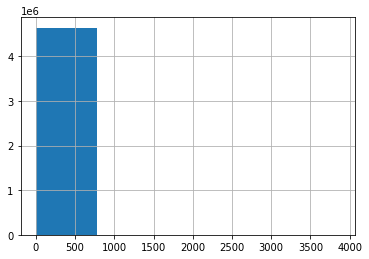

In [124]:
print(df_telcom_processed.describe())
df_telcom_processed['Internet_traffic_activity'].hist(bins=5)

          Square_id  Internet_traffic_activity
count  4.578305e+06               4.578305e+06
mean   6.079230e+03               1.334941e+01
std    2.605377e+03               1.688622e+01
min    3.800000e+01               5.836761e-06
25%    4.140000e+03               2.812119e+00
50%    6.225000e+03               7.470422e+00
75%    8.122000e+03               1.669310e+01
max    1.145400e+04               1.136228e+02


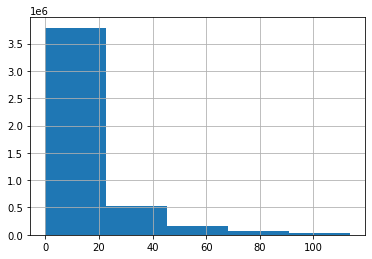

In [125]:
# remove outliers more than 3 sd
df_telcom_processed = df_telcom_processed[df_telcom_processed.Internet_traffic_activity < 1000]
df_telcom_processed = df_telcom_processed[np.abs(df_telcom_processed.Internet_traffic_activity-df_telcom_processed.Internet_traffic_activity.mean()) <= (3*df_telcom_processed.Internet_traffic_activity.std())]

# need to remove the outliers
print(df_telcom_processed.describe())
df_telcom_processed['Internet_traffic_activity'].hist(bins=5)


The histogram now is reasonable now that we have excluded the outliers.

In [126]:
# create temporal fields based on date and time
df_telcom_temporal = df_telcom_processed.copy()
df_telcom_temporal.loc[:,'Date'] = df_telcom_temporal.Timestamp.dt.date
df_telcom_temporal.loc[:,'Time'] = df_telcom_temporal.Timestamp.dt.time
df_telcom_temporal.loc[:,'Year'] = df_telcom_temporal.Timestamp.dt.year
df_telcom_temporal.loc[:,'Month'] = df_telcom_temporal.Timestamp.dt.month
df_telcom_temporal.loc[:,'day'] = df_telcom_temporal.Timestamp.dt.day
df_telcom_temporal.loc[:,'Quarter'] = df_telcom_temporal.Timestamp.dt.quarter
df_telcom_temporal.loc[:,'Weekday'] = df_telcom_temporal.Timestamp.dt.weekday
df_telcom_temporal.loc[:,'Hour'] = df_telcom_temporal.Timestamp.dt.hour

df_telcom_temporal

,Square_id,Timestamp,Internet_traffic_activity,Date,Time,Year,Month,day,Quarter,Weekday,Hour
0,10000,2013-12-01 00:00:00,9.381368,2013-12-01,00:00:00,2013,12,1,4,6,0
1,10000,2013-12-01 01:00:00,11.966050,2013-12-01,01:00:00,2013,12,1,4,6,1
2,10000,2013-12-01 02:00:00,10.588980,2013-12-01,02:00:00,2013,12,1,4,6,2
3,10000,2013-12-01 03:00:00,8.662089,2013-12-01,03:00:00,2013,12,1,4,6,3
4,10000,2013-12-01 04:00:00,7.491499,2013-12-01,04:00:00,2013,12,1,4,6,4
...,...,...,...,...,...,...,...,...,...,...,...
4646414,9999,2013-12-31 19:00:00,33.811344,2013-12-31,19:00:00,2013,12,31,4,1,19
4646415,9999,2013-12-31 20:00:00,32.427682,2013-12-31,20:00:00,2013,12,31,4,1,20
4646416,9999,2013-12-31 21:00:00,34.441008,2013-12-31,21:00:00,2013,12,31,4,1,21
4646417,9999,2013-12-31 22:00:00,32.575771,2013-12-31,22:00:00,2013,12,31,4,1,22


In [127]:
df_telcom_temporal.describe()

,Square_id,Internet_traffic_activity,Year,Month,day,Quarter,Weekday,Hour
count,4.578305e+06,4.578305e+06,4578305.0,4578305.0,4.578305e+06,4578305.0,4.578305e+06,4.578305e+06
mean,6.079230e+03,1.334941e+01,2013.0,12.0,1.597044e+01,4.0,2.935872e+00,1.146421e+01
std,2.605377e+03,1.688622e+01,0.0,0.0,8.929847e+00,0.0,2.077789e+00,6.931437e+00
min,3.800000e+01,5.836761e-06,2013.0,12.0,1.000000e+00,4.0,0.000000e+00,0.000000e+00
25%,4.140000e+03,2.812119e+00,2013.0,12.0,8.000000e+00,4.0,1.000000e+00,5.000000e+00
50%,6.225000e+03,7.470422e+00,2013.0,12.0,1.600000e+01,4.0,3.000000e+00,1.100000e+01
75%,8.122000e+03,1.669310e+01,2013.0,12.0,2.400000e+01,4.0,5.000000e+00,1.700000e+01
max,1.145400e+04,1.136228e+02,2013.0,12.0,3.100000e+01,4.0,6.000000e+00,2.300000e+01


Variation of internet usage per weekday is much less than the variation per hour

Find average usage in the time domain for Hour and Weekday

In [128]:
# compute the average hourly internet traffic
df_internet_hourly_LUT = df_telcom_temporal.groupby(['Hour'])['Internet_traffic_activity'].mean()
df_internet_hourly_LUT = pd.DataFrame({'Internet_traffic_hourly':df_internet_hourly_LUT})
df_processed_tmp = pd.merge(df_telcom_temporal,df_internet_hourly_LUT,how='left',on='Hour')

# compute the average internet traffic per weekday
df_internet_weekday_LUT = df_processed_tmp.groupby(['Weekday'])['Internet_traffic_activity'].mean()
df_internet_weekday_LUT = pd.DataFrame({'Internet_traffic_weekday':df_internet_weekday_LUT})
df_processed = pd.merge(df_processed_tmp,df_internet_weekday_LUT,how='left',on='Weekday')



In [129]:
df_univariate = df_processed.groupby(['Timestamp'])['Internet_traffic_activity'].mean()
y = pd.DataFrame({'Internet_traffic_activity_timestamp' : df_univariate.values})

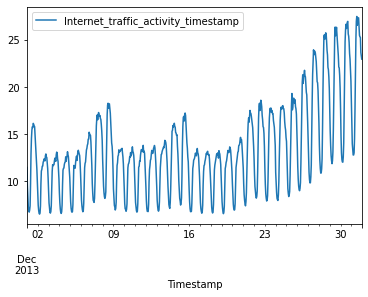

In [130]:
df_tmp_plot = df_telcom_temporal.copy()
df_tmp_plot = df_tmp_plot[['Timestamp']]
df_tmp_plot.drop_duplicates(inplace=True)
df_tmp_plot.reset_index(drop=True)
df_tmp_plot.loc[:,'Internet_traffic_activity_timestamp'] = y.Internet_traffic_activity_timestamp.values
df_tmp_plot[['Internet_traffic_activity_timestamp','Timestamp']].plot(x='Timestamp',y='Internet_traffic_activity_timestamp')

,Internet_traffic_activity
count,744.000000
mean,13.393356
std,4.789494
min,6.551075
25%,9.863139
50%,12.736743
75%,15.811894
max,27.442351


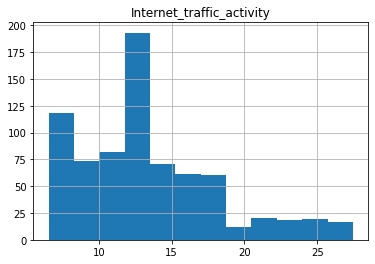

In [131]:
df_hist = df_univariate.reset_index(drop=False)
df_hist.hist(bins=12)
df_hist.describe()

Average internet traffic per timestamp

0     11.405326
1      9.844636
2      8.805889
3      8.241566
4      7.983418
5      7.969177
6      8.509251
7     10.065068
8     12.165131
9     13.857161
10    15.282616
11    16.072359
12    16.530970
13    16.331232
14    16.656280
15    16.731740
16    16.722870
17    16.594516
18    16.496248
19    16.096273
20    15.647479
21    15.220885
22    14.413860
23    13.288144
Name: Internet_traffic_hourly, dtype: float64

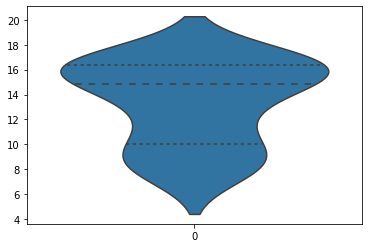

In [132]:
df_violin = df_processed['Internet_traffic_hourly'].drop_duplicates()
ax = sns.violinplot(data=df_violin,inner='quartile')
df_violin

The image shows the average internet usage per hour for all the square id.

In [133]:
# checking for missing values
print("Total number of observations\n",len(df_telcom_processed))
print("Total number of rows where the value is null\n",df_telcom_processed.isnull().sum())
print("Percentage of null values\n",round(df_telcom_processed.isnull().mean() * 100, 2))

Total number of observations
 4578305
Total number of rows where the value is null
 Square_id                    0
Timestamp                    0
Internet_traffic_activity    0
dtype: int64
Percentage of null values
 Square_id                    0.0
Timestamp                    0.0
Internet_traffic_activity    0.0
dtype: float64


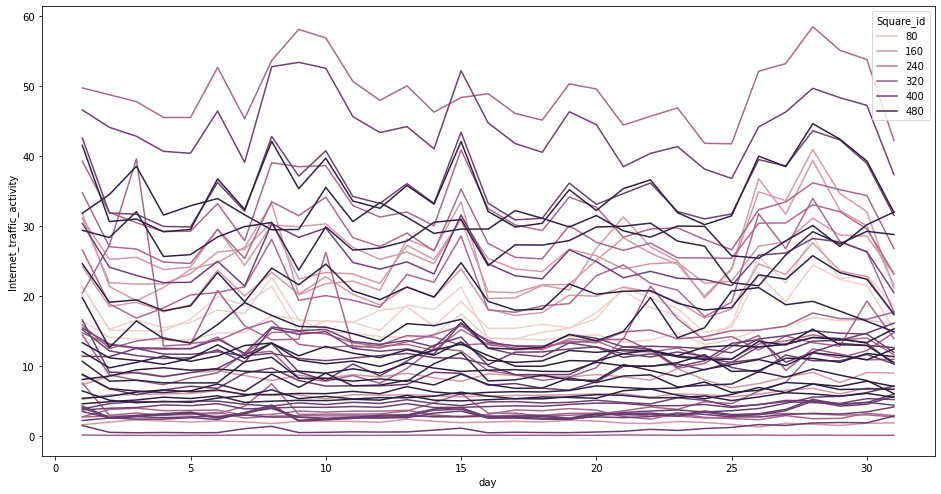

In [134]:
# explore internet usage per square id per date and time using lineplot
df_eda_day = df_processed.groupby(['Square_id','day'])['Internet_traffic_activity'].mean()
df_eda_day = df_eda_day.reset_index()  
df_eda_wide = df_eda_day.pivot("Square_id", "day", "Internet_traffic_activity")
square_id_used = df_eda_wide.iloc[:50,].index.tolist()
df_eda_day_plot = df_eda_day[df_eda_day['Square_id'].isin(square_id_used)]
fig, ax = plt.subplots()
sns.lineplot(x = 'day', y = 'Internet_traffic_activity', data=df_eda_day_plot, hue='Square_id', ax=ax)
fig.set_size_inches(16, 8.27)

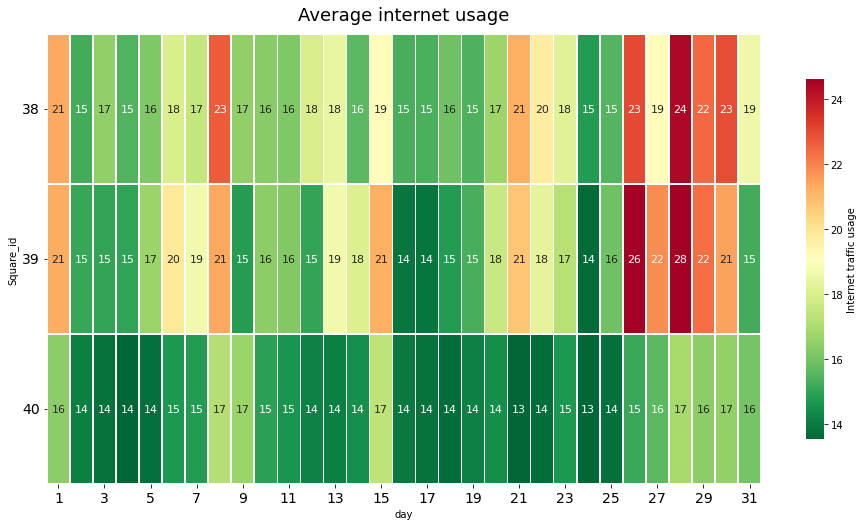

In [135]:
fig, ax = plt.subplots()
sns.heatmap(df_eda_wide.iloc[:3,],ax=ax,
            cmap='RdYlGn_r',
                 robust=True,
                #  fmt='.2f',
                 annot=True,
                 linewidths=.5,
                 annot_kws={'size':11},
                 cbar_kws={'shrink':.8,
                           'label':'Internet traffic usage'})                       
    
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=14)
plt.title('Average internet usage', fontdict={'fontsize':18},    pad=14)

fig.set_size_inches(16, 8.27);

We can observe than during the Christmas period some areas have increase data usage.

   Square_id                                           geometry
0         38  POLYGON ((10.91462 45.68201, 10.92746 45.68179...
1         39  POLYGON ((10.92746 45.68179, 10.94029 45.68157...
2         40  POLYGON ((10.94029 45.68157, 10.95312 45.68136...
3        154  POLYGON ((10.90209 45.69122, 10.91493 45.69100...
4        155  POLYGON ((10.91493 45.69100, 10.92777 45.69079...


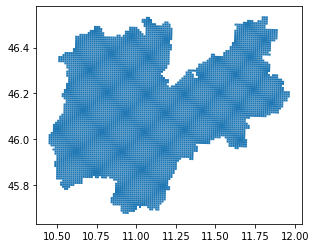

In [136]:
# import Spatial data for Trentino region
df_trentino_raw = gpd.read_file('/content/drive/MyDrive/Colab Notebooks/KPMG_Assignment/data/trentino-grid.geojson')
df_trentino_raw = df_trentino_raw.rename({'cellId':'Square_id'}, axis=1)
# output first five elements in dataframe
print(df_trentino_raw.head())
# plot spatial data
df_trentino_raw.plot()


Enrich the dataset with Cell Tower for LTE radio coverage. This will identigy possible areas where we need to deploy VSC in order to relief the network.

In [137]:
# read cell towers
df_temp1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/KPMG_Assignment/data/208.csv')
df_temp2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/KPMG_Assignment/data/222.csv')
df_cell_towers = pd.concat([df_temp1,df_temp2])

# drop duplicates if exist
df_cell_towers = df_cell_towers.drop_duplicates()

# restrict cell towers to area of interest
df_cell_towers = df_cell_towers[(df_cell_towers['lon'] > MIN_LON) &
                                (df_cell_towers['lon'] < MAX_LON) &
                                (df_cell_towers['lat'] > MIN_LAT) &
                                (df_cell_towers['lat'] < MAX_LAT) &
                                (df_cell_towers['radio'] == 'LTE')]

df_cell_towers


,radio,mcc,net,area,cell,unit,lon,lat,range,samples,changeable,created,updated,averageSignal
46771,LTE,222,1,16609,179642943,0,11.393509,45.731827,1939,15,1,1459739308,1491235467,0
196234,LTE,222,1,15812,179277098,0,11.344975,46.483887,1000,3,1,1418628040,1569467554,0
196513,LTE,222,10,23060,10150176,0,11.121444,46.061148,1000,2,1,1418816528,1539855930,0
196545,LTE,222,10,23060,10110987,0,11.118259,46.066313,1000,2,1,1418825335,1539855456,0
198199,LTE,222,10,23060,10150175,0,11.121772,46.064249,1000,2,1,1419428654,1539855884,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1242005,LTE,222,1,16911,180295999,-1,11.955315,45.883421,1000,15,1,1591006105,1591006164,0
1242006,LTE,222,1,16914,180220477,-1,11.954255,45.884441,1000,5,1,1591006135,1591006144,0
1242007,LTE,222,1,16914,180220457,-1,11.943572,45.895321,1134,36,1,1591006165,1591006320,0
1242008,LTE,222,1,16909,180238122,-1,11.934742,45.909474,1726,32,1,1591006225,1591006531,0


In [138]:
# convert cell towers to geopandas
gdf_cell_towers = gpd.GeoDataFrame(df_cell_towers,
                                   geometry=gpd.points_from_xy(df_cell_towers.lon, 
                                                               df_cell_towers.lat))
# keep only cell_tower id and geometry columns
gdf_cell_towers = gdf_cell_towers[['geometry']]
gdf_cell_towers.reset_index(drop=True)

,geometry
0,POINT (11.39351 45.73183)
1,POINT (11.34497 46.48389)
2,POINT (11.12144 46.06115)
3,POINT (11.11826 46.06631)
4,POINT (11.12177 46.06425)
...,...
4674,POINT (11.95531 45.88342)
4675,POINT (11.95425 45.88444)
4676,POINT (11.94357 45.89532)
4677,POINT (11.93474 45.90947)


In [139]:
# find the mean usage per square id
df_telcom_averaged = df_processed[['Internet_traffic_activity','Square_id']].groupby(by='Square_id').mean()

# join the averate internet traffic with map data
df_trentino_processed = pd.merge(df_trentino_raw, df_telcom_processed, on="Square_id")
# reduce the dataset to become manageable
df_trentino_reduced = df_trentino_processed.iloc[1:len(df_trentino_processed):70, :]
df_trentino_reduced


,Square_id,geometry,Timestamp,Internet_traffic_activity
1,38,"POLYGON ((10.91462 45.68201, 10.92746 45.68179...",2013-12-01 01:00:00,10.326146
71,38,"POLYGON ((10.91462 45.68201, 10.92746 45.68179...",2013-12-03 23:00:00,12.275907
141,38,"POLYGON ((10.91462 45.68201, 10.92746 45.68179...",2013-12-06 21:00:00,17.432931
211,38,"POLYGON ((10.91462 45.68201, 10.92746 45.68179...",2013-12-09 19:00:00,18.732011
281,38,"POLYGON ((10.91462 45.68201, 10.92746 45.68179...",2013-12-12 17:00:00,23.834756
...,...,...,...,...
4578001,11454,"POLYGON ((11.81824 46.53634, 11.83126 46.53601...",2013-12-19 04:00:00,13.303376
4578071,11454,"POLYGON ((11.81824 46.53634, 11.83126 46.53601...",2013-12-22 02:00:00,31.040498
4578141,11454,"POLYGON ((11.81824 46.53634, 11.83126 46.53601...",2013-12-25 00:00:00,36.140168
4578211,11454,"POLYGON ((11.81824 46.53634, 11.83126 46.53601...",2013-12-27 22:00:00,76.861519


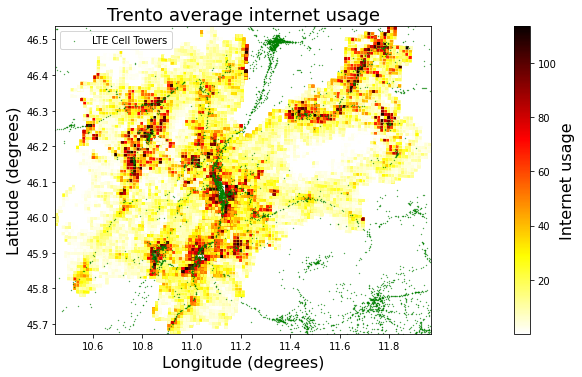

In [140]:
# plot area with cell towers
fig, ax = plt.subplots(figsize = (10,12))  
ax.set_xlabel("Longitude (degrees)",fontsize=16)
ax.set_ylabel("Latitude (degrees)",fontsize=16)
gdf_cell_towers.plot(markersize=0.1,
                     c='green',
                     ax=ax,
                     label='LTE Cell Towers',
                     zorder=2)
leg = ax.legend(loc='upper left')
plt.title('Trento average internet usage',fontsize=18)
# plot internet traffic data
df_trentino_reduced.plot(ax=ax,
                         zorder=1,
                         column='Internet_traffic_activity',
                         cmap = "hot_r")
# add legend to plot
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.0001)
# create the colorbar
norm = plt.Normalize(vmin=df_trentino_reduced.Internet_traffic_activity.min(),
                        vmax=df_trentino_reduced.Internet_traffic_activity.max())
cbar = plt.cm.ScalarMappable(norm=norm, cmap='hot_r')
# add colorbar
ax_cbar = fig.colorbar(cbar, ax=ax, cax=cax)
# add label for the colorbar
ax_cbar.set_label('Internet usage',
                  fontsize=16)
# set plot limits to area of interest
ax.set_ylim(ymin=MIN_LAT)
ax.set_ylim(ymax=MAX_LAT)
ax.set_xlim(xmin=MIN_LON)
ax.set_xlim(xmax=MAX_LON)
plt.show()

Future steps:
 - Explore in more detail as to why some square id have more internet usage
 - Identify areas with high demand. Perform spatiotemporal analysis of internet usage
 - Identify areas with high usage but not good coverage